# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час прибегнув к помощи ML.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.  

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('.../datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Имеется линейный ряд данных по заказу такси за промежуток от 1 марта 2018 года по 31 августа 2018 года.

## Анализ данных и подготовка признаков

### Изучение цикличность и тренда

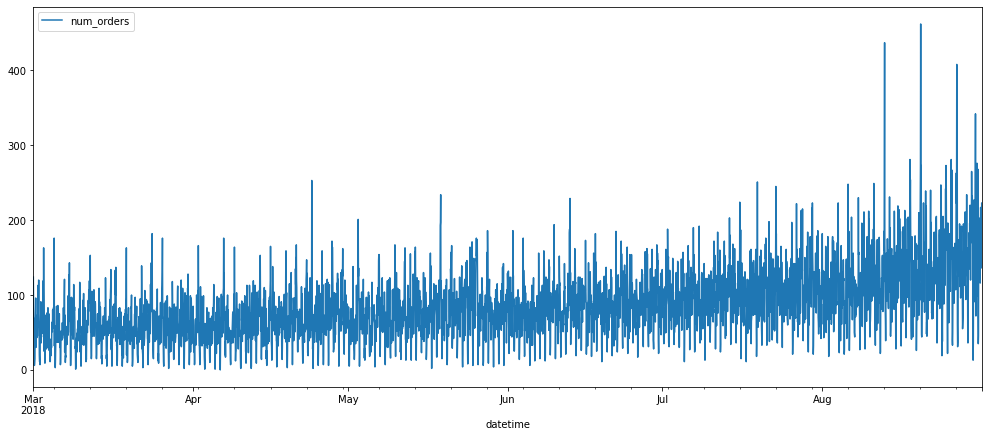

In [5]:
plt.rcParams["figure.figsize"] = (17,7)
data.plot();

Имеем график заказов за все время, видно, что есть пики, видно, что в августе их больше.

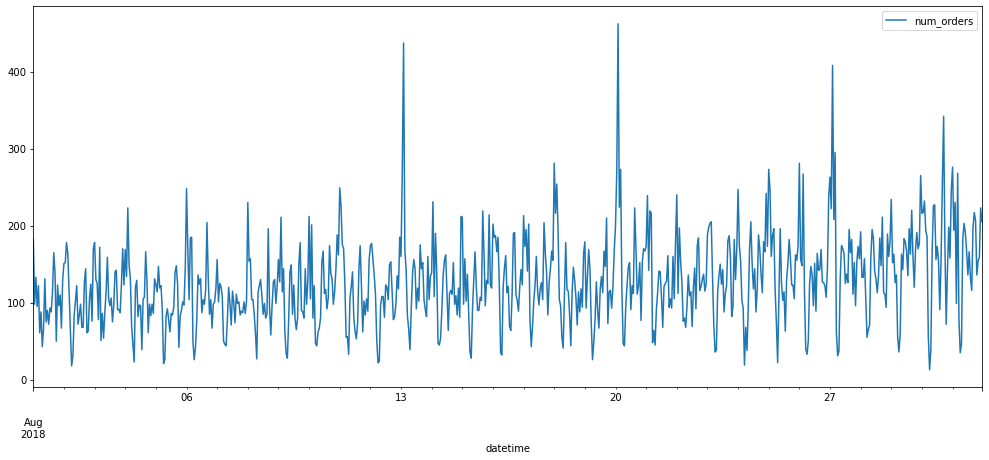

In [6]:
plt.rcParams["figure.figsize"] = (17,7)
data['2018-08-01' : '2018-08-31'].plot();

График за август показывает более четко пики, но в целом, картина по дням более-менее одннобразна. Надо вглянуть на тренд и сезонность (дневную)

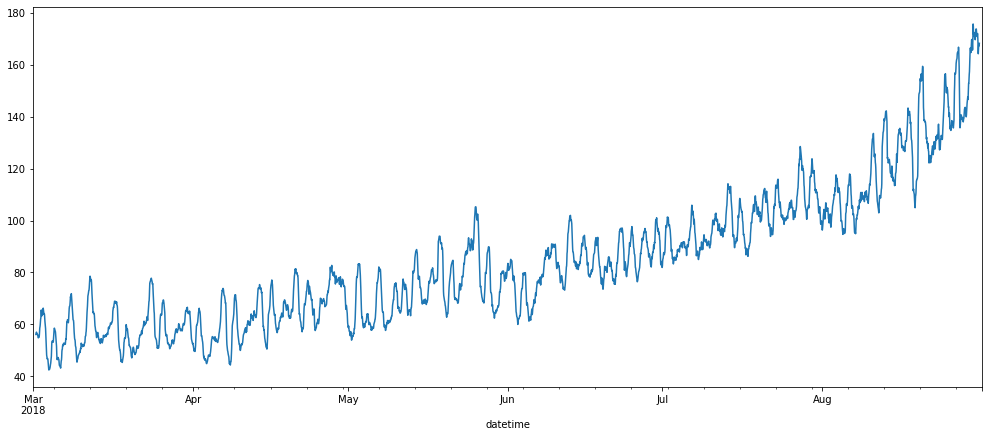

In [7]:
decomposed = seasonal_decompose(data)

decomposed.trend.plot();

Тренд показываает четкий рост числа заказов в предоставленном промежутке дат, думаю, что это связано с пиковыми значениями в августе.

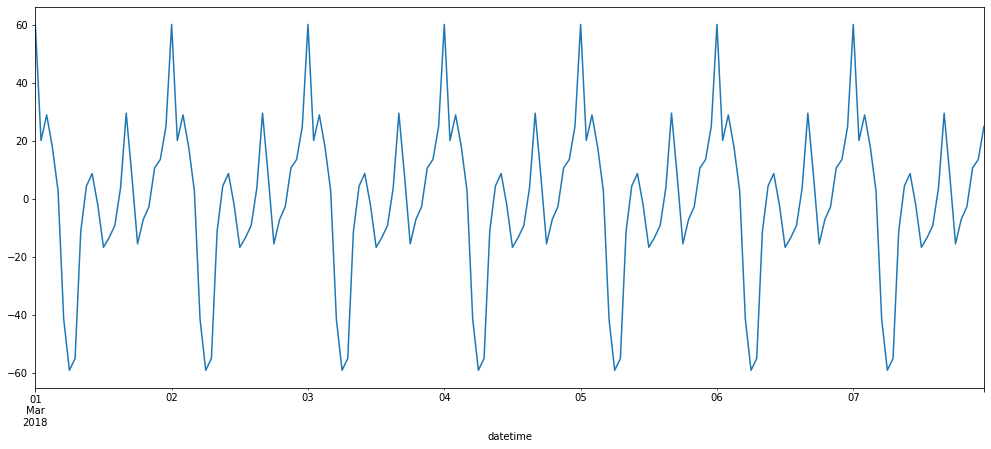

In [8]:
decomposed.seasonal['2018-03-01' : '2018-03-07'].plot();

Сезонность по дням. Четкая и выраженная. Отлично видно 2 пика на утро (все едут на работу), и большой пик с микроподъемом вечером (все едут с работы). И провалы по ночам.

### Подбор оптимального числа признаков

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    new_data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_' + str(lag)] = data['num_orders'].shift(lag)

    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return (new_data)

Подготовил функцию для создания фичей. Специально сделал ее так, чтобы она возвращала новый фрейм для облечгения работы цикла по подбору количества фичей.

In [11]:
data = make_features(data, 1, 24)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

tr_ft = train.drop('num_orders', axis=1)
tr_tg = train.num_orders

ts_ft = test.drop('num_orders', axis=1)
ts_tg = test.num_orders

In [12]:
tscv = TimeSeriesSplit(n_splits=6)

Данные готовы, можно идти учиться. В этом разделе были проанализированы данные, из результатов анализа видно, что данные имеют выраженную цикличность/сезонность, связанную с естественной деятельностью людей, также количество заказов имеет тренд к росту их числа. В фичи не вводил год, поскольку данные не за полный год, также в фичи не вводил месяц, поскольку неизвестно какой тренд будет в дальнейшем. Подобрал количество фичей. Также была подготовлена функция для разделения временных данных в фолды для гридсерча. Количество 6 выбрал исходя из количества месяцев в тренировочной выборке.

## Обучение

In [13]:
final_met = pd.DataFrame(index=['RMSE'])

### Dummy

In [14]:
model = DummyRegressor()

model.fit(tr_ft, tr_tg)

tr_pr = model.predict(tr_ft)
ts_pr = model.predict(ts_ft)

print("RMSE обучающей выборки:", mean_squared_error(tr_pr, tr_tg)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(ts_pr, ts_tg)**0.5)
final_met['Dummy'] = round(mean_squared_error(tr_pr, tr_tg)**0.5, 2)

RMSE обучающей выборки: 38.68289405726269
RMSE тестовой выборки:  84.6499381993622


Болванка выдает 84 на тестовой выборке. Решил сделать для болванки исключение и прогнать ее на тесте.

### LGBM

In [15]:
LGBMR_params = {
    'num_leaves': range(100, 201, 20),
    'max_depth': range(5, 11, 1),
    'n_estimators': range(200, 401, 50)
}

LGBMR_GR = GridSearchCV(LGBMRegressor(random_state=13),
                        param_grid=LGBMR_params,
                        scoring='neg_root_mean_squared_error',
                        cv=tscv,
                        verbose=1,
                        n_jobs=-1)

In [16]:
%%time
LGBMR_GR.fit(tr_ft, tr_tg)

Fitting 6 folds for each of 180 candidates, totalling 1080 fits
CPU times: total: 1.62 s
Wall time: 8.63 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
             estimator=LGBMRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': range(5, 11),
                         'n_estimators': range(200, 401, 50),
                         'num_leaves': range(100, 201, 20)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [17]:
print(LGBMR_GR.best_estimator_)
print("RMSE на кросс-валидации:", LGBMR_GR.best_score_ * -1)
final_met['LGBM'] = round(LGBMR_GR.best_score_ * -1, 2)

LGBMRegressor(max_depth=5, n_estimators=200, num_leaves=100, random_state=13)
RMSE на кросс-валидации: 26.27450737344904


In [18]:
LGBM_pred = pd.DataFrame(tr_tg)
LGBM_pred['prediction'] = LGBMR_GR.predict(tr_ft)

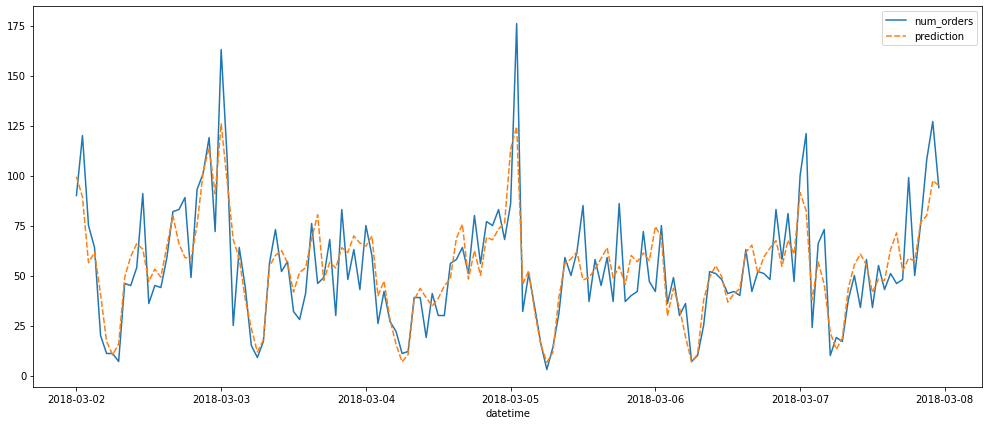

In [19]:
sns.lineplot(data=LGBM_pred['2018-03-01' : '2018-03-07']);

### Linear Regression

In [20]:
model = LinearRegression()

RMSE_LR = cross_val_score(model,
                          tr_ft,
                          tr_tg,
                          cv=tscv,
                          n_jobs=-1,
                          scoring='neg_root_mean_squared_error').mean() * -1

print('Значение метрики RMSE на обучающей выборке для LinearRegression',
      RMSE_LR)

final_met['LR'] = round(RMSE_LR, 2)

Значение метрики RMSE на обучающей выборке для LinearRegression 31.56521601453055


In [21]:
LR_pred = pd.DataFrame(tr_tg)
LR_pred['prediction'] = model.fit(tr_ft, tr_tg).predict(tr_ft)

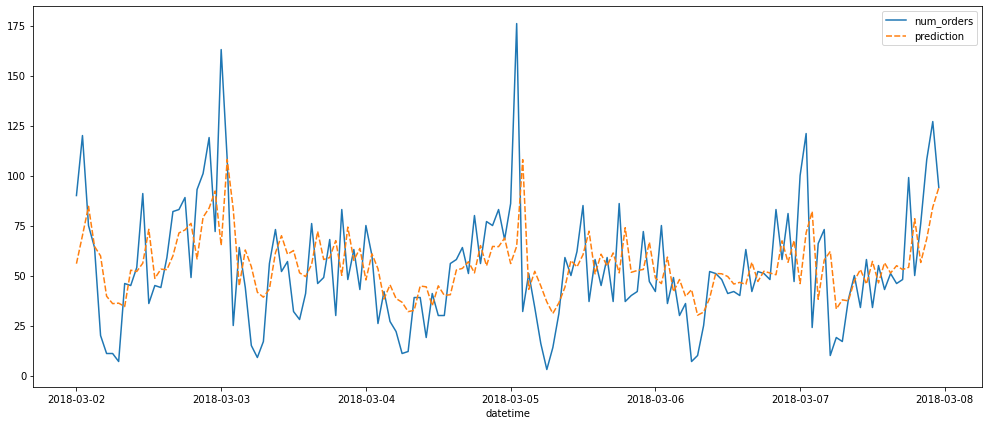

In [22]:
sns.lineplot(data=LR_pred['2018-03-01' : '2018-03-07']);

### Decision Tree

In [23]:
LR_DT = GridSearchCV(DecisionTreeRegressor(random_state=13),
                        scoring='neg_root_mean_squared_error',
                        param_grid = {'max_depth': range(3, 12)},
                        cv=tscv,
                        verbose=1,
                        n_jobs=-1)

In [24]:
%%time
LR_DT.fit(tr_ft, tr_tg)

Fitting 6 folds for each of 9 candidates, totalling 54 fits
CPU times: total: 109 ms
Wall time: 154 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
             estimator=DecisionTreeRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': range(3, 12)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [25]:
print(LR_DT.best_estimator_)
print("RMSE на кросс-валидации:", LR_DT.best_score_ * -1)
final_met['DT'] = round(LR_DT.best_score_ * -1, 2)

DecisionTreeRegressor(max_depth=7, random_state=13)
RMSE на кросс-валидации: 28.94104386629286


In [26]:
DT_pred = pd.DataFrame(tr_tg)
DT_pred['prediction'] = LR_DT.predict(tr_ft)

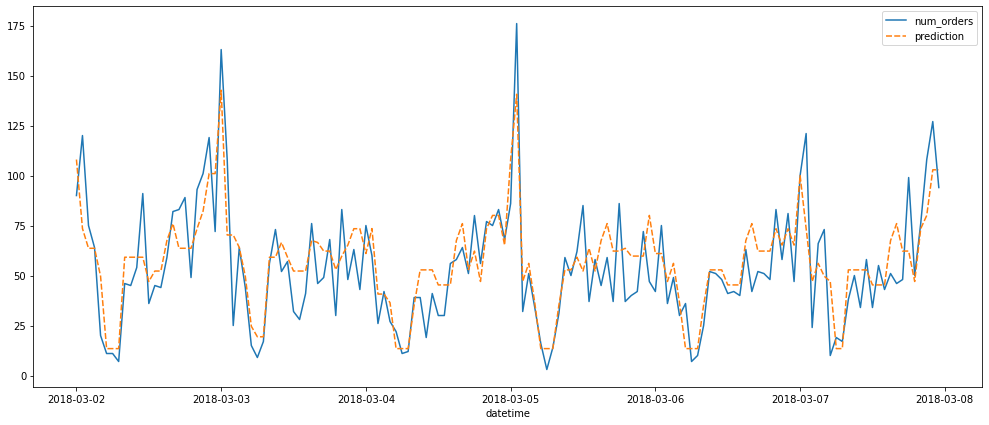

In [27]:
sns.lineplot(data=DT_pred['2018-03-01' : '2018-03-07']);

### Random Forest

In [28]:
LR_RF = GridSearchCV(RandomForestRegressor(random_state=13),
                        scoring='neg_root_mean_squared_error',
                        param_grid = {'max_depth': range(7, 13), 'n_estimators': range(100, 151, 10)},
                        cv=tscv,   
                        verbose=1,
                        n_jobs=-1)

In [29]:
%%time
LR_RF.fit(tr_ft, tr_tg)

Fitting 6 folds for each of 36 candidates, totalling 216 fits
CPU times: total: 1.11 s
Wall time: 5.45 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
             estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': range(7, 13),
                         'n_estimators': range(100, 151, 10)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [30]:
print(LR_RF.best_estimator_)
print("RMSE на кросс-валидации:",LR_RF.best_score_ * -1)
final_met['RF'] = round(LR_RF.best_score_ * -1, 2)

RandomForestRegressor(max_depth=12, n_estimators=140, random_state=13)
RMSE на кросс-валидации: 25.403027210164776


In [31]:
RF_pred = pd.DataFrame(tr_tg)
RF_pred['prediction'] = LR_RF.predict(tr_ft)

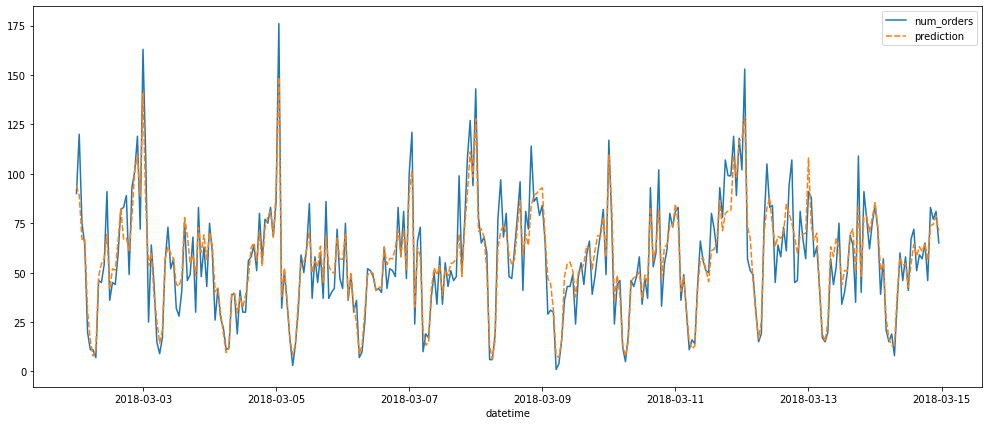

In [32]:
sns.lineplot(data=RF_pred['2018-03-01' : '2018-03-14']);

In [33]:
final_met.T.sort_values(by='RMSE', ascending=True)

,RMSE
RF,25.40
LGBM,26.27
DT,28.94
LR,31.57
Dummy,38.68


Итак, виден победитель.

### Финальная модель и тестовая выборка

In [34]:
print("RMSE на RF на тестовой выборке:", round((mean_squared_error(LR_RF.predict(ts_ft), ts_tg)**0.5), 1))

RMSE на RF на тестовой выборке: 47.9


In [35]:
fin_pred = pd.DataFrame(ts_tg)
fin_pred['prediction'] = LR_RF.predict(ts_ft)

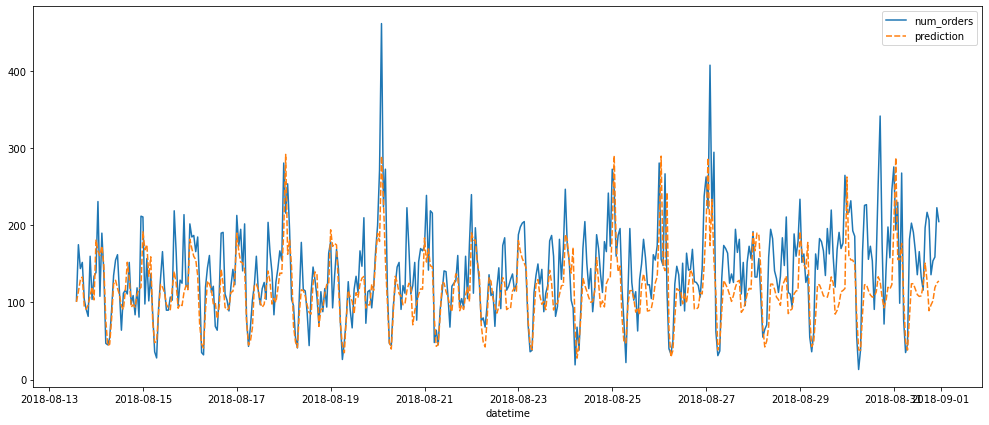

In [36]:
sns.lineplot(data=fin_pred);

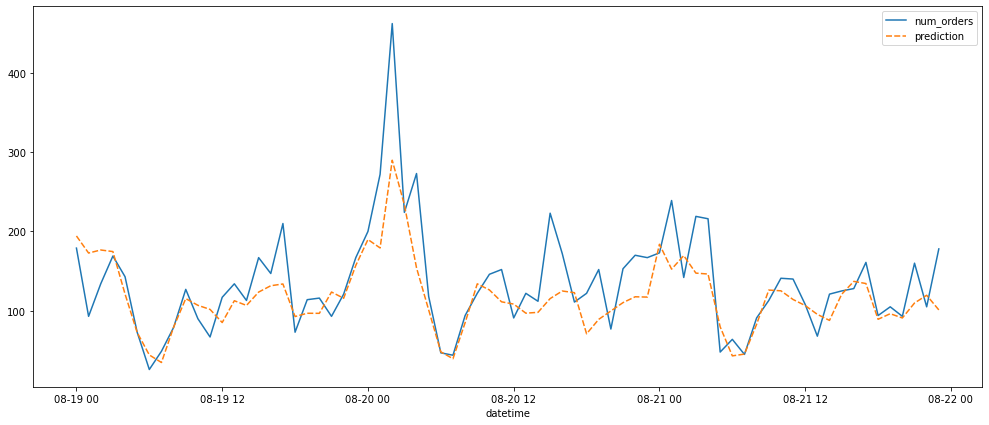

In [37]:
sns.lineplot(data=fin_pred['2018-08-19' : '2018-08-21']);

На графике видно, что модель относительно близко повторяет целевые значения. В основном модель, как и выше все модели, теряет пиковые значения, стараясь сгладить график.

## Итоговый вывод

В рамках данной работы проведен анализ временного ряда данных по количеству вызовов такси с целью предсказания количества вызовов в ближайший час. Для достижения цели был проведен ресемпл по часу, были изучены тренд и цикличность, после чего было определено оптимальное количество фичей (1 лаг) и размер окна скользящего среднего (24 часа), дополнительные фичи были обоснованы логически. 
Модели обучались методом кросс-валидации в гридсерче, далее лучшая модель - случайный лес была испытана на тестовой выборке, где продемонстрировала уровень RMSE 47.9, что соответствует требованиям заказчика - достичь уровня метрики ниже 48.